In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
from HPA_CC.data.dataset import RefCLSDM, RefImDM, load_labels
from HPA_CC.models.train import find_checkpoint_file, ClassifierLit, PseudoRegressorLit
from HPA_CC.models.models import PseudoRegressor
classes = ["M-G1", "G1", "S-G2", "G2"]

In [2]:
log_dirs_home = Path("/data/ishang/pseudotime_pred/")

In [3]:
model_name = "HPA DINO Classifier"
model_hash = "1gu6u2qu" # int focal scope
# model_hash = "ee9r9c1l" # int soft focal
# model_hash = "sltskj1m" # soft focal scope
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
label_type = "phase" # "phase", "angle", or "pseudotime"
scope = True # Only used for phase

In [4]:
# model_name = "HPA DINO Angle Regressor"
# model_hash = "u0livnza"
# repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
# ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
# int_stats = True # were intensity statistics added to the embedding? (not used from conv)
# label_type = "angle" # "phase", "angle", or "pseudotime"
# scope = None

In [5]:
# model_name = "HPA DINO Pseudotime Regressor"
# model_hash = "81peszw2"
# repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
# ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
# int_stats = False # were intensity statistics added to the embedding? (not used from conv)
# label_type = "pseudotime" # "phase", "angle", or "pseudotime"
# scope = None

In [6]:
split = (0.64, 0.16, 0.2)
data_dir = Path("/data/ishang/FUCCI-dataset-well")
data_name = "minimal"
device = "cuda:0"

In [8]:
if repr_type == "conv":
    dataset = RefImDM(data_dir, data_name, 32, 1, split, label_type, scope)
else:
    dataset = RefCLSDM(data_dir, data_name, batch_size=32, num_workers=1, split=split, 
                       hpa=(repr_type == "hpa_dino"), label=label_type, scope=scope, concat_well_stats=int_stats)
phase_labels = load_labels("phase", data_dir, data_name, scope=(False if scope is None else True))

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([31732, 1536])
X shape: torch.Size([31732, 2048])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt
Y shape: torch.Size([31732, 4])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt


In [16]:
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
if label_type == "phase":
    model = ClassifierLit.load_from_checkpoint(checkpoint_file)
else:
    model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
model.to(device)
model.eval()


ClassifierLit(
  (model): Classifier(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=2048, out_features=4, bias=True)
    )
    (loss_fn): FocalLoss(alpha=None, gamma=2.0, ignore_index=-100, reduction='mean')
  )
)

In [17]:
preds_list = []
with torch.no_grad():
    for batch in iter(dataset.test_dataloader()):
        x, y = batch
        x = x.to(device)
        preds_list.append(model(x).cpu())
preds_test = torch.cat(preds_list, dim=0).numpy()
labels_test = dataset.dataset.Y[dataset.split_indices["test"]]
phase_labels_test = phase_labels[dataset.split_indices["test"]]
print(preds_test.shape, labels_test.shape, phase_labels_test.shape)

(6346, 4) torch.Size([6346, 4]) torch.Size([6346, 4])


In [18]:
if label_type != "phase":
    preds_list = []
    with torch.no_grad():
        for batch in iter(dataset.val_dataloader()):
            x, y = batch
            x = x.to(device)
            preds_list.append(model(x).cpu())

    preds_val = torch.cat(preds_list, dim=0)
    preds_val = PseudoRegressor.angle_to_pseudo(preds_val).numpy().flatten()
    labels_val = dataset.dataset.Y[dataset.split_indices["val"]]
    phase_labels_val = phase_labels[dataset.split_indices["val"]]
    phase_labels_val = np.argmax(phase_labels_val, axis=1)

    bins = np.linspace(0, 1, 21)
    binned_preds_val = np.digitize(preds_val, bins)

    bins_round = np.round(bins, 2)
    df = pd.DataFrame({'Binned Predictions': bins_round[binned_preds_val], 'Phase Labels': phase_labels_val})
    crosstab = pd.crosstab(df['Binned Predictions'], df['Phase Labels'])
    crosstab_normalized = crosstab.apply(lambda row: row / row.sum(), axis=1)
    crosstab_normalized.plot.bar(stacked=True)
    plt.xlabel('Binned Predictions')
    plt.ylabel('Proportion')
    plt.title('Proportion of Phase Labels for Binned Predictions')
    plt.legend(title='Phase Labels')
    plt.show()
    plt.clf()

    int_size = 75
    x = np.linspace(0, 1, 100)
    df = pd.DataFrame({'Predictions': preds_val, 'Label Angle': labels_val})
    g = sns.jointplot(data=df, x='Predictions', y='Label Angle', kind='hex', marginal_kws=dict(bins=50))
    ax = g.ax_joint
    ax.plot(x, x, color='black', linestyle='--')
    plt.show()


In [19]:
if label_type != "phase":
    cutoffs = [0.0]
    for label in np.unique(phase_labels_val):
        cutoffs.append(torch.max(labels_val[phase_labels_val == label]).item())
    cutoffs[-1] = 1.0
    print(cutoffs)

    # cutoffs = [0, 0.2, 0.5, 0.7, 1.0]
    # cutoffs = [0, 0.05, 0.5, 0.7, 1.0]
    colors = ['darkred', 'red', 'orange', 'green']
    labels_val_n = labels_val.numpy()
    bins = np.linspace(0, 1, 100)
    for c in range(len(cutoffs) - 1):
        cutoff_labels = labels_val_n[(labels_val_n < cutoffs[c+1]) & (labels_val_n > cutoffs[c])]
        plt.hist(cutoff_labels, bins=bins, alpha=0.5, label=classes[c], color=colors[c])
    plt.show()

    plt.clf()
    for c in range(len(cutoffs) - 1):
        cutoff_labels = preds_val[(preds_val < cutoffs[c+1]) & (preds_val > cutoffs[c])]
        plt.hist(cutoff_labels, bins=bins, alpha=0.5, label=classes[c], color=colors[c])
    plt.show()

In [20]:
if label_type == "phase":
    preds_test = np.argmax(preds_test, axis=1)
    labels_test = np.argmax(labels_test, axis=1)
    pred_phase_test = preds_test
    label_phase_test = labels_test
    print(preds_test.shape, labels_test.shape)
else:
    pred_labels_test = np.zeros_like(preds_test)
    pred_pseudo_test = PseudoRegressor.angle_to_pseudo(torch.Tensor(preds_test)).numpy()
    for c in range(len(cutoffs) - 1):
        pred_labels_test[(pred_pseudo_test < cutoffs[c+1]) & (pred_pseudo_test > cutoffs[c])] = c
    pred_phase_test = pred_labels_test
    label_phase_test = np.argmax(phase_labels_test, axis=1)

(6346,) torch.Size([6346])


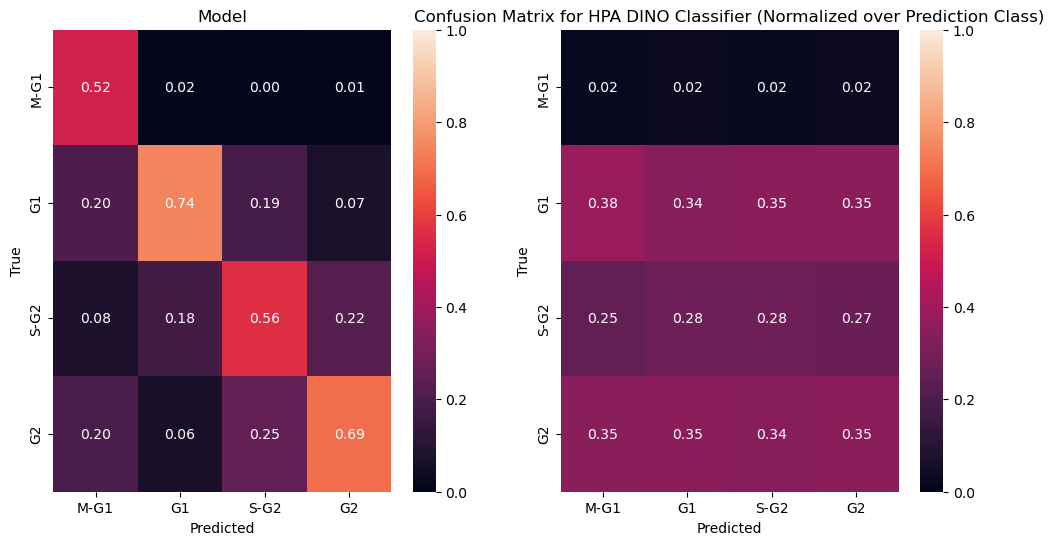

In [24]:
filler = np.arange(len(classes))
preds_ = np.concatenate((pred_phase_test.flatten(), filler))
labels_ = np.concatenate((label_phase_test.flatten(), filler))
null_labels = np.concatenate((np.random.choice(filler, len(label_phase_test)), filler))
cm = confusion_matrix(labels_, preds_).astype(np.float32)
cm = cm - np.identity(len(classes))
cm = cm / np.sum(cm, axis=0, keepdims=True)
cm_null = confusion_matrix(labels_, null_labels).astype(np.float32)
cm_null = cm_null - np.identity(len(classes))
cm_null = cm_null / np.sum(cm_null, axis=0, keepdims=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt=".2f", vmin=0, vmax=1.0, ax=ax1)
ax1.set_xlabel("Predicted")
ax1.xaxis.set_ticklabels(classes)
ax1.set_ylabel("True")
ax1.yaxis.set_ticklabels(classes)
ax1.set_title(f"{model_name} (Normalized over Prediction Class)")
sns.heatmap(cm_null, annot=True, fmt=".2f", vmin=0, vmax=1.0, ax=ax2)
ax2.set_xlabel("Predicted")
ax2.xaxis.set_ticklabels(classes)
ax2.set_ylabel("True")
ax2.yaxis.set_ticklabels(classes)
ax2.set_title("Null Model")
plt.show()

In [22]:
bins = np.linspace(0, 1, 26)
preds_test_pseudo_n = PseudoRegressor.angle_to_pseudo(torch.Tensor(preds_test)).numpy()
binned_preds_test = np.digitize(preds_test_pseudo_n, bins).flatten()
if label_type != "phase":
    label_phase_test_n = label_phase_test.numpy().flatten()
    p_x_y = np.zeros((len(bins) - 1, len(classes)))
    for i in range(len(bins) - 1):
        for j in range(len(classes)):
            p_x_y[i, j] = np.sum((binned_preds_test == i) & (label_phase_test_n == j))

    # Probability of x given y
    p_x_given_y = p_x_y / np.sum(p_x_y, axis=0, keepdims=True)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    for j in range(len(classes)):
        ax.plot(bins[:-1], p_x_given_y[:, j], label=f'{classes[j]}')
    plt.xlabel('Binned Predictions')
    plt.ylabel('Probability')
    plt.title('Probability of x given y')
    plt.legend(title='Phase Labels')
    plt.show()

    # Probability of y given x
    p_y_given_x = p_x_y / np.sum(p_x_y, axis=1, keepdims=True)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    for j in range(len(classes)):
        sns.lineplot(x=bins[:-1], y=p_y_given_x[:, j], label=f'{classes[j]}', ax=ax)
    ax2 = ax.twinx()
    ax2.hist(preds_test_pseudo_n, bins=bins, alpha=0.2, label='Predictions', color='purple', density=True)
    plt.xlabel('Phase Labels')
    plt.ylabel('Probability')
    plt.title('Probability of y given x')
    plt.legend(title='Binned Predictions')
    plt.show()
